# Load Manhattan muti-modal datasets

In [49]:
import os 
import glob 
import pandas as pd
import geopandas as gpd
from shapely import Point
from datetime import datetime
import pandas as pd
import numpy as np

FOLDER_PATH = '../../../../data/rrochas/raw_data/Manhattan'
SAVE_PATH = '../../../../data/rrochas/prediction_validation/Manhattan'

# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# Load city bike data: 
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
year = 2021
month = 1
bike_save_path  = f'{SAVE_PATH}/city_bike_{year}'
df_test = pd.read_csv(f'{bike_save_path}/{month:02d}_15min_emitted.csv',index_col=0,dtype={0: str} )  # specify first column as string



# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# Load Subway data: 
# ------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------
# df_subway_4h = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Turnstile_Usage_Data__2021_20250812.csv',index_col=0)
df_subway_4h = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Turnstile_Usage_Data__2022_20250812.csv',index_col=0)

df_subway_4h.rename(columns={'Exits                                                     ': 'Exits'}, inplace=True)
gdf = gpd.read_file(f'{SAVE_PATH}/subway_stations.shp',crs = 'EPSG:4326',index_col=0)



# According to this medium url https://medium.com/qri-io/taming-the-mtas-unruly-turnstile-data-c945f5f96ba0
# suppose to use the three one to get the spatial matching : 
if False: 
    subway_entry_exits = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Entrances_and_Exits__2024_20250813.csv',index_col=0)
    remote_df = pd.read_excel(f'{FOLDER_PATH}/Remote-Booth-Station.xls', index_col=0) 
    gdf = gpd.read_file(f'{SAVE_PATH}/subway_stations.shp',crs = 'EPSG:4326',index_col=0)


# But found this Kaggle dataset which has been already preprocessed and contains the station and matching with 'Unit':
# https://www.kaggle.com/datasets/eddeng/nyc-subway-traffic-data-20172021/data?select=station_lookup.csv
station_lookup = pd.read_csv(f'{FOLDER_PATH}/station_lookup.csv', index_col=0) 
gdf = gpd.read_file(f'{SAVE_PATH}/subway_stations.shp',crs = 'EPSG:4326',index_col=0)


# (!) When Merging, it removes 1 station ID from gdf: 
if True:
    # --- Merging : 
    # Get correspondance : 
    mask = ~station_lookup['complex_id'].isna()
    station_lookup = station_lookup[mask].copy()
    station_lookup['complex_id'] = station_lookup['complex_id'].astype(int)
    station_lookup.rename(columns={'complex_id': 'Complex ID'}, inplace=True)

    # Merge gdf : 
    gdf = gdf[['GTFS Stop', 'Station ID','Complex ID','Division', 'Line','Stop Name', 'geometry']].merge(station_lookup[['Complex ID', 'booth']].reset_index(), how='inner', on = 'Complex ID')
    gdf.rename(columns={'remote ': 'remote'}, inplace=True)

## Preprocessing of the 4-hours aggregated MTA datasets :

In [35]:
# ---- Reduce df_subway_4h to only manhattan stations: 
reduced_df_subway_4h = df_subway_4h[df_subway_4h['Unit'].isin(gdf['remote'])].copy()
reduced_df_subway_4h = reduced_df_subway_4h.reset_index()
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# ---- Convert Date and Time to datetime:
reduced_df_subway_4h['Date']=reduced_df_subway_4h['Date'].str.strip()
reduced_df_subway_4h['Time']=reduced_df_subway_4h['Time'].str.strip()
reduced_df_subway_4h['Time'] = pd.to_datetime(reduced_df_subway_4h['Time']).dt.strftime('%H:%M:%S') # Convert Time HH:MM:SS AM or HH:MM:SS PM to HH:MM:SS format
datetime_str = reduced_df_subway_4h['Date'] + ' ' + reduced_df_subway_4h['Time']
coerced_dates = pd.to_datetime(datetime_str, errors='coerce')
mismatched_rows = reduced_df_subway_4h[coerced_dates.isna()]
assert len(mismatched_rows) == 0, f"There are {len(mismatched_rows)} rows with mismatched dates or times in the dataset."
reduced_df_subway_4h['datetime'] = coerced_dates
# ---- 
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# ----  Get Net Entries and Exits:
# Get unique unit_id 
reduced_df_subway_4h['unit_id'] = reduced_df_subway_4h.apply(lambda row: f"{row['Unit']}_{row['C/A']}_{row['SCP']}",axis=1)

# Compute differences in Entries and Exits at each unique unit_id:
reduced_df_subway_4h.sort_values(by=['unit_id', 'datetime'], inplace=True)
reduced_df_subway_4h['Net_Entries'] = reduced_df_subway_4h.groupby('unit_id')['Entries'].diff()
reduced_df_subway_4h['Net_Exits'] = reduced_df_subway_4h.groupby('unit_id')['Exits'].diff()
reduced_df_subway_4h['Net_Flow'] = reduced_df_subway_4h['Net_Entries'] - reduced_df_subway_4h['Net_Exits']
# ---- 
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# ---- Clean up the DataFrame by removing rows with Negatives values, too large time interval, or extreme outliers :
# Init 
abnormal_time_interval = 24 # hours 
flow_threshold = 15000  

# Tackle Negative Values 
init_df_shape = len(reduced_df_subway_4h)
df_cleaned = reduced_df_subway_4h[(reduced_df_subway_4h['Net_Entries'] >= 0) & (reduced_df_subway_4h['Net_Exits'] >= 0)].copy()
print(f"Pourcentage of Remaining rows after removing negative values : {len(df_cleaned)/init_df_shape:2f}%")

# Tackle Abnormal time intervales: 
df_cleaned['time_diff'] = df_cleaned.groupby('unit_id')['datetime'].diff()
time_threshold = pd.Timedelta(hours=abnormal_time_interval)
df_cleaned = df_cleaned[df_cleaned['time_diff'] <= time_threshold]
df_cleaned = df_cleaned.drop(columns=['time_diff'])
print(f"Pourcentage of Remaining rows after removing anormal time interval :  {len(df_cleaned)/init_df_shape:2f}%")

#Tackle Flow threshold:
df_cleaned = df_cleaned[(df_cleaned['Net_Entries'] < flow_threshold) &(df_cleaned['Net_Exits'] < flow_threshold)]
print(f"Pourcentage of Remaining rows after removing outliers:  {len(df_cleaned)/init_df_shape:2f}%")
# ----
# ----------------------------------------------------------------


# ----------------------------------------------------------------
# ---- Sum through all turnstiles: 
df_entries = df_cleaned.groupby(['Unit','datetime']).agg(Net_Entries=('Net_Entries', 'sum')).unstack(level=0)
df_entries.columns = df_entries.columns.droplevel(0)
df_exits = df_cleaned.groupby(['Unit','datetime']).agg(Net_Exits=('Net_Exits', 'sum')).unstack(level=0)
df_exits.columns = df_exits.columns.droplevel(0)
df_flows = df_cleaned.groupby(['Unit','datetime']).agg( Net_Flow=('Net_Flow', 'sum')).unstack(level=0)
df_flows.columns = df_flows.columns.droplevel(0)
# ----
# ----------------------------------------------------------------

/tmp/ipykernel_127262/3638533626.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  reduced_df_subway_4h['Time'] = pd.to_datetime(reduced_df_subway_4h['Time']).dt.strftime('%H:%M:%S') # Convert Time HH:MM:SS AM or HH:MM:SS PM to HH:MM:SS format


Pourcentage of Remaining rows after removing negative values : 0.987612%
Pourcentage of Remaining rows after removing anormal time interval :  0.987039%
Pourcentage of Remaining rows after removing outliers:  0.987026%


## Now need to interpolate the 4 hours aggregated data into 1h aggregated data:

In [456]:
display(df_exits)
display(df_exits.resample('4h').sum())

Unit,R001,R010,R011,R012,R013,R014,R015,R016,R017,R020,...,R344,R345,R452,R453,R461,R462,R463,R570,R571,R572
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 08:00:00,284.0,NaN,NaN,NaN,NaN,290.0,NaN,NaN,NaN,NaN,...,NaN,NaN,517.0,NaN,253.0,123.0,216.0,344.0,170.0,211.0
2022-01-01 09:00:00,NaN,731.0,NaN,NaN,NaN,NaN,207.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 11:00:00,NaN,NaN,1676.0,1307.0,811.0,NaN,NaN,107.0,524.0,1266.0,...,26.0,96.0,NaN,262.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-01-01 12:00:00,1169.0,NaN,NaN,NaN,NaN,1523.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1602.0,NaN,1120.0,502.0,1011.0,586.0,544.0,346.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 19:00:00,NaN,NaN,10367.0,9616.0,1903.0,NaN,NaN,1104.0,571.0,19106.0,...,69.0,923.0,NaN,2762.0,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-30 20:00:00,4666.0,NaN,NaN,NaN,NaN,7000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,5832.0,NaN,6786.0,3260.0,3896.0,3353.0,3105.0,2295.0
2022-12-30 21:00:00,NaN,6804.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Unit,R001,R010,R011,R012,R013,R014,R015,R016,R017,R020,...,R344,R345,R452,R453,R461,R462,R463,R570,R571,R572
datetime,,,,,,,,,,,,,,,,,,,,,
2022-01-01 08:00:00,284.0,731.0,1676.0,1307.0,811.0,290.0,207.0,107.0,524.0,1266.0,...,26.0,96.0,517.0,262.0,253.0,123.0,216.0,344.0,170.0,211.0
2022-01-01 12:00:00,1169.0,1533.0,2527.0,2455.0,1401.0,1523.0,1003.0,176.0,912.0,2350.0,...,43.0,164.0,1602.0,436.0,1120.0,502.0,1011.0,586.0,544.0,346.0
2022-01-01 16:00:00,1845.0,3004.0,3575.0,3002.0,2187.0,2439.0,1579.0,234.0,1027.0,3592.0,...,51.0,254.0,2619.0,693.0,2169.0,1215.0,2046.0,936.0,886.0,612.0
2022-01-01 20:00:00,1447.0,3522.0,2817.0,1575.0,952.0,2422.0,699.0,149.0,695.0,1352.0,...,32.0,185.0,2266.0,345.0,1597.0,1174.0,1586.0,1226.0,1365.0,1004.0
2022-01-02 00:00:00,917.0,1042.0,664.0,519.0,256.0,1247.0,148.0,82.0,248.0,324.0,...,13.0,104.0,1189.0,88.0,526.0,308.0,442.0,859.0,901.0,741.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-30 04:00:00,472.0,524.0,1096.0,1274.0,352.0,454.0,27.0,353.0,160.0,2385.0,...,20.0,66.0,408.0,445.0,235.0,88.0,138.0,308.0,467.0,471.0
2022-12-30 08:00:00,1013.0,2138.0,4218.0,4301.0,1367.0,2473.0,15.0,1326.0,645.0,12734.0,...,63.0,227.0,1780.0,1953.0,1167.0,544.0,615.0,2268.0,865.0,842.0
2022-12-30 12:00:00,5919.0,3808.0,5710.0,5911.0,2395.0,6242.0,25.0,845.0,443.0,14104.0,...,79.0,354.0,5244.0,2105.0,4764.0,2684.0,3651.0,4122.0,2256.0,1467.0


<Axes: xlabel='datetime'>

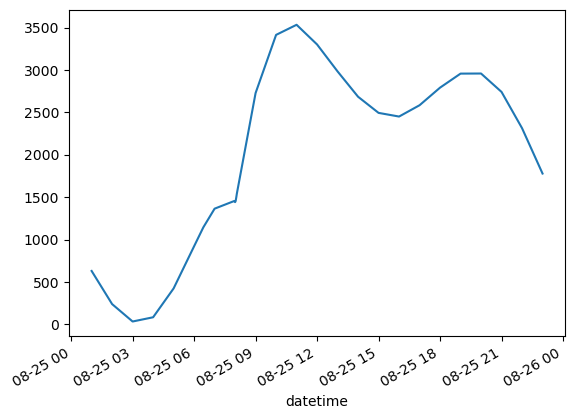

In [ ]:

df_interpolated = df_exits.copy()
df_interpolated = df_interpolated.interpolate(method='spline', order=3)
mean_df_interpolated = df_interpolated.mean(1)
mean_df_interpolated[(mean_df_interpolated.index > datetime(2022,8,25) )& (mean_df_interpolated.index < datetime(2022,8,26))].plot()

# Interpolation with CubicSpline: 

<Axes: >

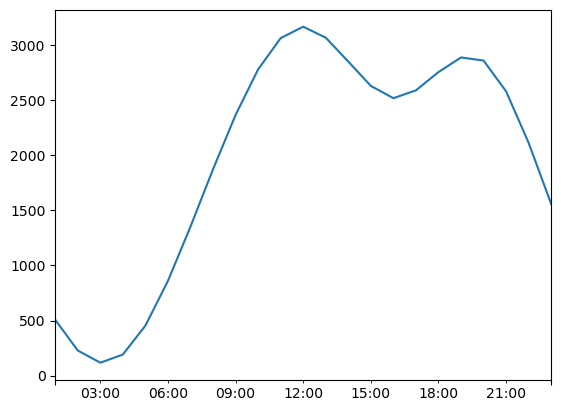

In [306]:
from scipy.interpolate import CubicSpline

y = df_exits.resample('4h').sum()
x = y.index

xs = pd.date_range(start=df_entries.index.min(), end=df_entries.index.max(), freq='1h')
cs = CubicSpline(x, y, axis=0)


#
mean_subway_checkout = pd.DataFrame(cs(xs),index = xs).mean(axis=1)
mean_subway_checkout[(mean_subway_checkout.index > datetime(2022,8,25) )& (mean_subway_checkout.index < datetime(2022,8,26))].plot()

# Load 'Subway Hourly Ridership from https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/about_data

## Way too much missing values. > 90% at each stations

In [120]:
import os 
import glob 
import pandas as pd
import geopandas as gpd
from shapely import Point
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import csv

from load_inputs.systematic_analysis.utils import get_histogram_per_day_type,get_boxplot_per_spatial_unit_per_day_type,heatmap
from load_inputs.systematic_analysis.utils import IN_bdc,OUT_bdc,IN_nbdc,OUT_nbdc

ROOT = '../../../../data/rrochas'
FOLDER_PATH = f'{ROOT}/raw_data/Manhattan'
SAVE_PATH = f'{ROOT}/prediction_validation/Manhattan'

if False: 
    for year in [2020, 2021, 2022,2023]:
        MTA_hourly_year = []
        for month in range(1,13):
        
            MTA_hourly = pd.read_csv(f'{FOLDER_PATH}/Subway_Hourly/MTA_Turnstile_Manhattan_{year}_{month}.csv', 
                                    index_col=0,
                                    )
            MTA_hourly.index = pd.to_datetime(MTA_hourly.index)
            MTA_hourly = MTA_hourly.sort_index()
            # Convert into str:
            MTA_hourly['station_complex_id'] = MTA_hourly['station_complex_id'].astype(str)
            # Filter TRAM1 and TRAM2 stations: 
            MTA_hourly = MTA_hourly[~MTA_hourly['station_complex_id'].str.startswith(('TRAM1', 'TRAM2'))].copy()
            # Stats: 

            MTA_hourly = MTA_hourly.reset_index().pivot_table(index = 'transit_timestamp', columns = 'station_complex_id', values = 'ridership').sort_index()
            MTA_hourly.index.name = 'date'
            MTA_hourly.columns.name = 'Spatial Unit ID'

            MTA_hourly_year.append(MTA_hourly)
        
        MTA_hourly_year = pd.concat(MTA_hourly_year)
        print('Number of unique days', len(set(MTA_hourly_year.index.date)))
        print('Number of station_complex_id in df', MTA_hourly_year.columns.nunique())
        MTA_hourly_year.to_csv(f'{SAVE_PATH}/MTA_Turnstile_Manhattan_hourly_{year}.csv')
else:
    MTA_hourly = []
    for year in [2021, 2022,2023]:
        MTA_hourly_year = pd.read_csv(f'{SAVE_PATH}/MTA_Turnstile_Manhattan_hourly_{year}.csv', index_col=0)
        MTA_hourly_year.index = pd.to_datetime(MTA_hourly_year.index)
        MTA_hourly_year = MTA_hourly_year.fillna(0)
        MTA_hourly.append(MTA_hourly_year)
    MTA_hourly = pd.concat(MTA_hourly)
display(MTA_hourly.head())

,10,103,107,118,119,13,14,143,144,145,...,619,622,623,624,625,628,635,8,9,301
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00,8.0,2.8,3.400000,4.25,9.428571,2.666667,3.6,1.400000,1.333333,1.00,...,8.5,13.714286,4.5,7.428571,11.0,17.0,6.000000,8.800000,26.333333,0.0
2021-01-01 01:00:00,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2021-01-01 02:00:00,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.00,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0
2021-01-01 04:00:00,0.0,0.0,1.000000,0.00,1.000000,1.000000,1.0,2.000000,1.000000,1.00,...,1.5,2.000000,2.0,2.250000,2.0,1.5,1.333333,0.000000,2.000000,0.0
2021-01-01 05:00:00,4.0,1.0,2.333333,1.50,2.250000,1.200000,1.0,4.428571,3.333333,1.25,...,2.4,3.000000,2.2,3.333333,5.0,9.5,5.625000,1.333333,2.400000,0.0


# EDA :

Number of remaining time-slots after filtering 18234
Number of remaining time-slots after filtering 8030


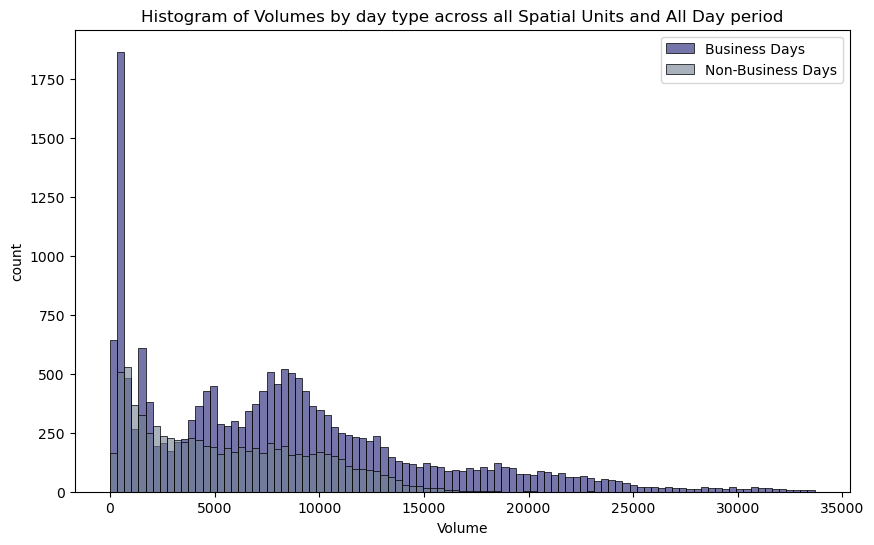

Number of remaining time-slots after filtering 3040
Number of remaining time-slots after filtering 1340


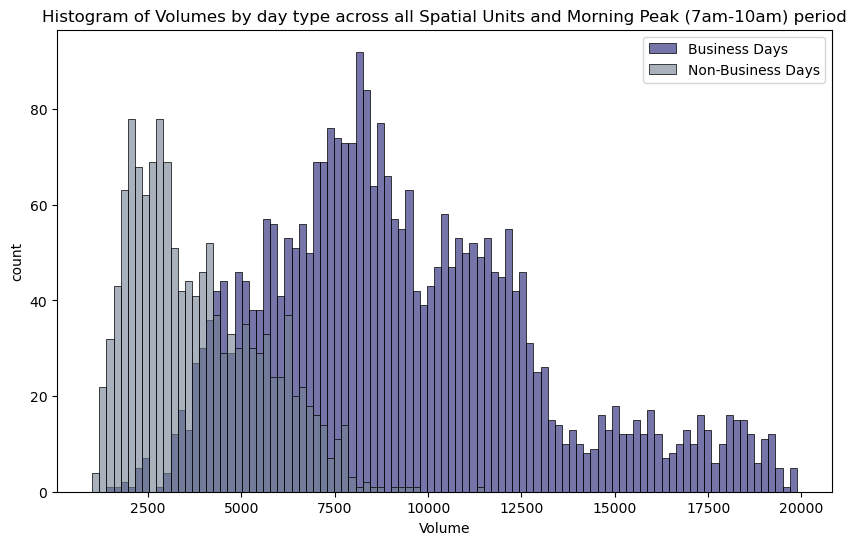

Number of remaining time-slots after filtering 2280
Number of remaining time-slots after filtering 1005


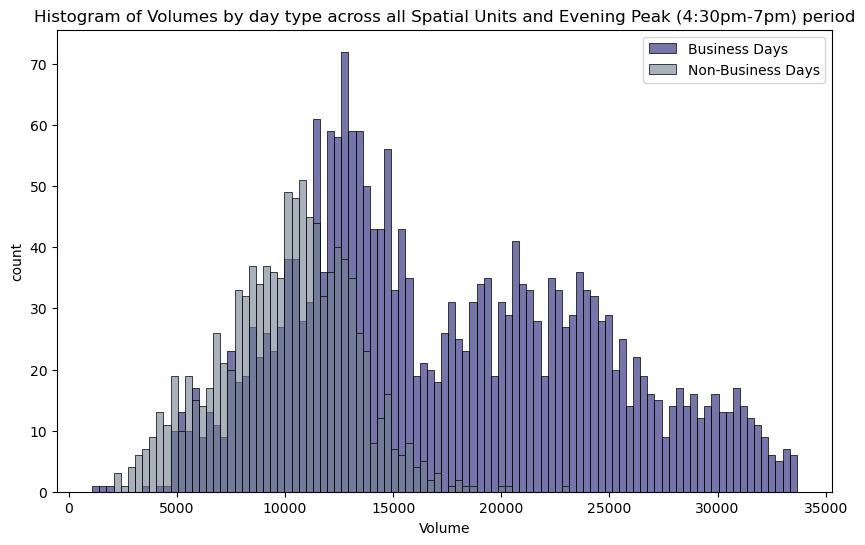

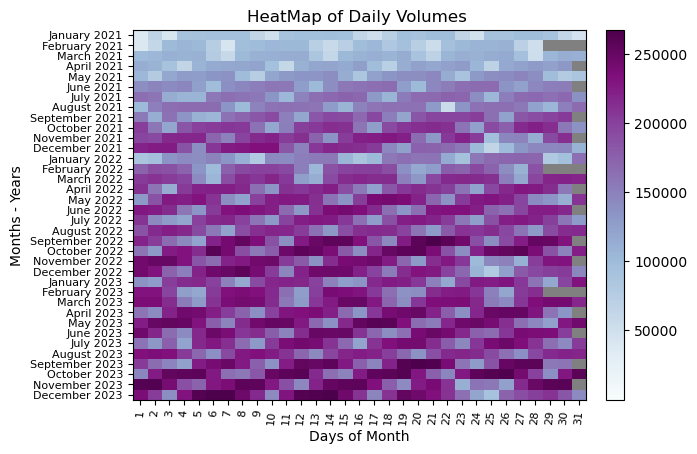

In [121]:
stats = 'count'
signal = 'in'
mode = 'manhattan_subway'
city = 'Manhattan'
df_raw = MTA_hourly.copy()
palette = [IN_bdc, IN_nbdc]


# ==== Histogram ====
for period in ['all_day','morning_peak','evening_peak']:
    folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/{mode}"
    save_path = f'{folder}/{mode}_hist_{signal}_{period}.pdf'# None 
    ts_bd, ts_nbd = get_histogram_per_day_type(df_raw,city= city,period = period,stats = stats, palette = palette,n_bins = 100,save_path= save_path)

# ==== Boxplot ====
if False: 
    # Too much stations -> impossible to use: 
    df_raw.columns.name = 'Spatial Unit ID'
    for period in ['all_day','morning_peak','evening_peak']:
        folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/{mode}_boxplot"
        save_path = f'{folder}/{mode}_boxplot_{signal}_{period}.pdf'# None
        df_bd, df_nbd = get_boxplot_per_spatial_unit_per_day_type(df_raw,period = period,city= city, palette = palette,save_path = save_path,df_all = df_raw)

# ==== HeatMap ====
cmap = 'BuPu' # 'hot' #'YlOrRd' # 'RdYlBu'
bool_reversed= False 
folder = f"../../../home/rrochas/prediction-validation/load_inputs/systematic_analysis/plots/{mode}/{mode}_heatmap"

save_path = f'{folder}/{mode}_heatmap_{city}.pdf'# None
df_agg = heatmap(df_raw,city= city,cmap = cmap,bool_reversed = bool_reversed,
                 save_path = save_path )

# Spatial visualisation: 

In [123]:
import pandas as pd
import numpy as np
import geopandas as gpd 
from IPython.display import display, HTML
import html # Import the standard 'html' library


gdf = gpd.read_file(f'{ROOT}/prediction_validation//Manhattan/subway_stations.shp',crs = 'EPSG:4326',index_col=0)
print('Number of subway stations in Manhattan: ',gdf['Station ID'].nunique())

gdf_from_flows = gpd.GeoDataFrame(MTA_hourly.groupby('station_complex_id').agg({'latitude': 'first',
                                                                                      'longitude': 'first',
                                                                                      'ridership': 'sum',
                                                                                      })
                                                                                      )
gdf_from_flows = gdf_from_flows.set_geometry(gpd.points_from_xy(gdf_from_flows.longitude, gdf_from_flows.latitude))
gdf_from_flows.crs = 'EPSG:4326'

gdf_from_flows['ridership_100k'] = gdf_from_flows['ridership'] / 1000000


m = gdf_from_flows.explore('ridership_100k',
        tiles = 'CartoDB positron', 
        marker_type = 'circle',
        style_kwds={'style_function': lambda x: {'radius': np.sqrt(x['properties']['ridership'])/30},
                        'cmap': 'viridis',
                        'fill': True,
                    },
        legend_kwds={'caption': 'Ridership in Millions'}
        )


map_html_string = m._repr_html_()
escaped_map_html = html.escape(map_html_string, quote=True)
iframe_html = f'<iframe srcdoc="{escaped_map_html}" width="{800}" height="{400}" style="border:none;"></iframe>'
display(HTML(iframe_html))
print('Number of plotted complex IDs:', len(gdf_from_flows))


KeyError: 'Spatial Unit ID'

# Load Bike Datasets : 

In [132]:
# Quelques trou: 
# - Le 2 février 2021 
# - Le 21 Aout 2021
# - Un usage bien différent du vélo des français: utilisation principalement lors de période plus chaude. Non utilisé en hiver.

import matplotlib.pyplot as plt

local_folder_path = '../../../../data/rrochas/prediction_validation/Manhattan/'

freq = '1H'  # '15min' # '1H' # '30min
All_df_pivoted_bike = []
All_nb_bike_stations = []
for year in [2021, 2022]:
    for month in range(1,13):
        # 01_15min_emitted.csv
        path = f"{SAVE_PATH}/city_bike_{year}/{month:02d}_{freq}_emitted.csv"
        df_bike = pd.read_csv(path,index_col=0,dtype={0: str, 1:str, 2:int}) # specify columns dtypes
        df_bike['started_at'] = pd.to_datetime(df_bike['started_at'])
        nb_bike_stations = df_bike.index.nunique()

        # Pivoted bike:
        df_pivoted_bike = df_bike.reset_index().pivot_table(index='started_at', columns='start_station_id', values='Flow').fillna(0).sort_index()
        df_pivoted_bike = df_pivoted_bike[df_pivoted_bike.index > datetime(2021,month,1)]

        All_df_pivoted_bike.append(df_pivoted_bike)
        All_nb_bike_stations.append(nb_bike_stations)

# Concatenate all pivoted bike dataframes:
pivoted_bike = pd.concat(All_df_pivoted_bike, axis=0).sort_index()
print(f"Total number of active bike stations per month:")
for month, nb_stations in enumerate(All_nb_bike_stations, start=1):
    print(f"Year {2021 + (month-1)//12} Month {(month%12):02d}: {nb_stations} stations")

print(f"Total number of unique bike stations across all months: {pivoted_bike.columns.nunique()}")
print(f"Number of stations with more than 1 Flow per hour: {(pivoted_bike.mean() > 0.12).sum()}")
print(f"Number of stations with more than 1 Flow per 15min: {(pivoted_bike.mean() > 2).sum()}")

Total number of active bike stations per month:
Year 2021 Month 01: 1286 stations
Year 2021 Month 02: 1337 stations
Year 2021 Month 03: 1397 stations
Year 2021 Month 04: 1457 stations
Year 2021 Month 05: 1499 stations
Year 2021 Month 06: 1479 stations
Year 2021 Month 07: 1490 stations
Year 2021 Month 08: 1489 stations
Year 2021 Month 09: 1491 stations
Year 2021 Month 10: 1566 stations
Year 2021 Month 11: 1575 stations
Year 2021 Month 00: 1583 stations
Year 2022 Month 01: 1596 stations
Year 2022 Month 02: 1615 stations
Year 2022 Month 03: 1613 stations
Year 2022 Month 04: 1615 stations
Year 2022 Month 05: 1620 stations
Year 2022 Month 06: 1633 stations
Year 2022 Month 07: 1654 stations
Year 2022 Month 08: 1665 stations
Year 2022 Month 09: 1695 stations
Year 2022 Month 10: 1713 stations
Year 2022 Month 11: 1743 stations
Year 2022 Month 00: 1767 stations
Total number of unique bike stations across all months: 1878
Number of stations with more than 1 Flow per hour: 1757
Number of stations 

# EDA Bike Dataset:

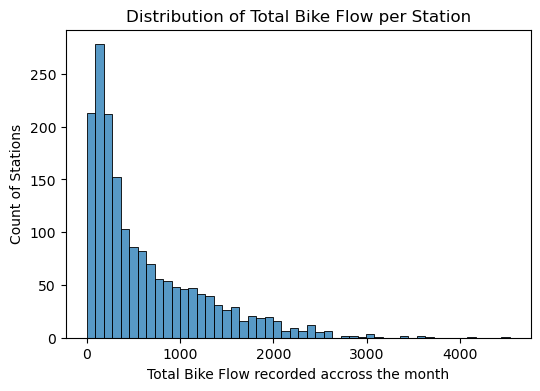

In [133]:
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.histplot(df_pivoted_bike.sum(), bins=50)
plt.title('Distribution of Total Bike Flow per Station')
plt.xlabel('Total Bike Flow recorded accross the month')
plt.ylabel('Count of Stations')
plt.show()

<Axes: xlabel='started_at'>

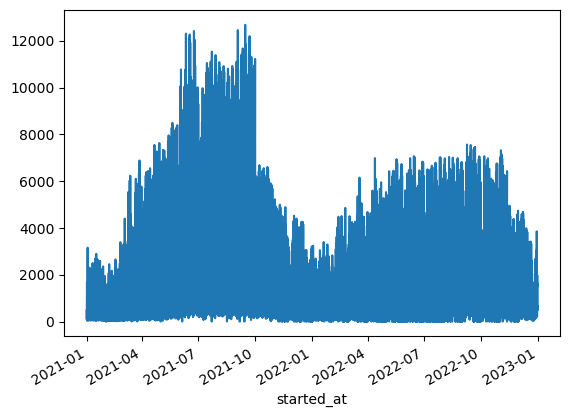

In [134]:
pivoted_bike.sum(1).plot()

Number of remaining time-slots after filtering 12313
Number of remaining time-slots after filtering 5727


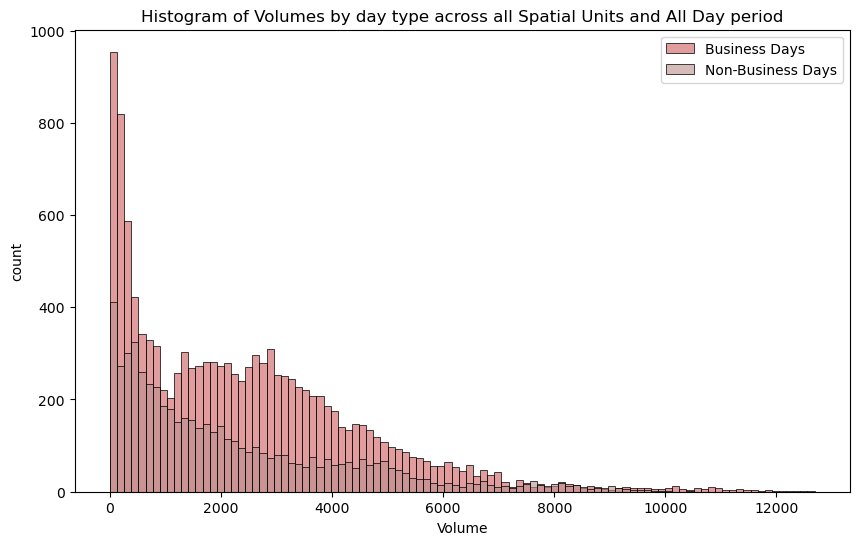

Number of remaining time-slots after filtering 2047
Number of remaining time-slots after filtering 940


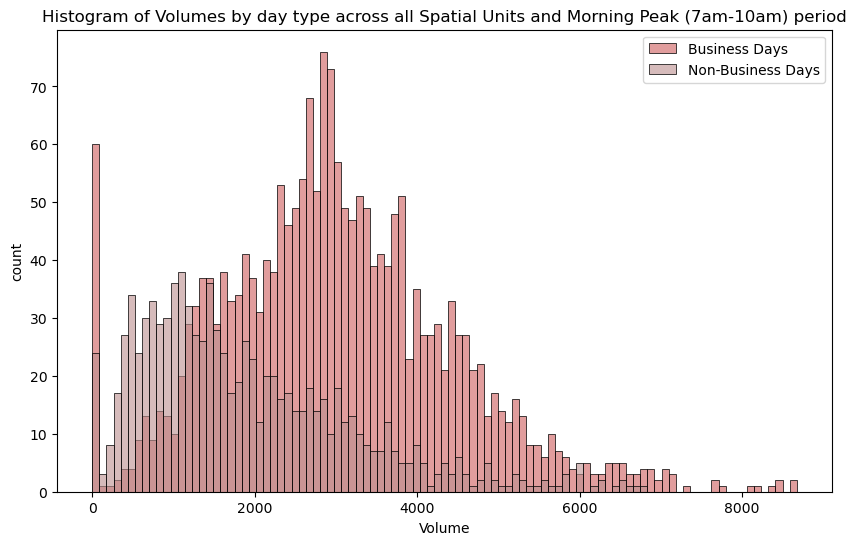

Number of remaining time-slots after filtering 1560
Number of remaining time-slots after filtering 728


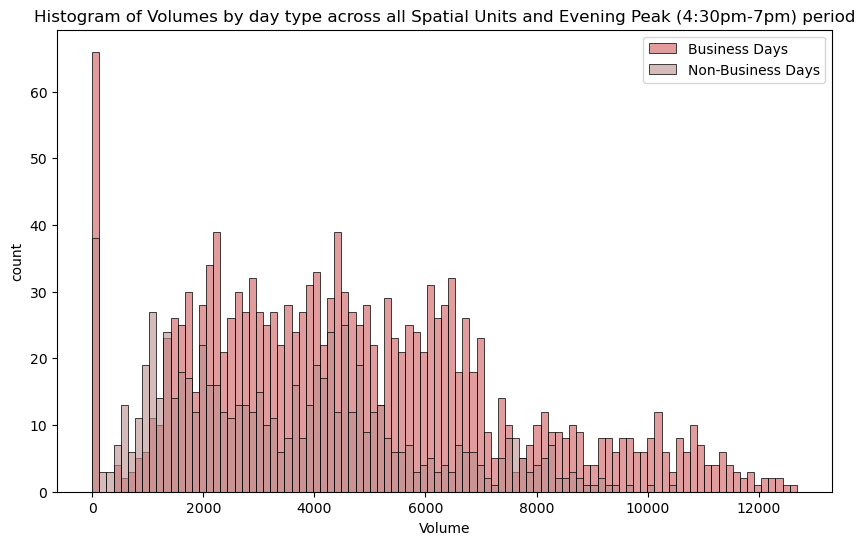

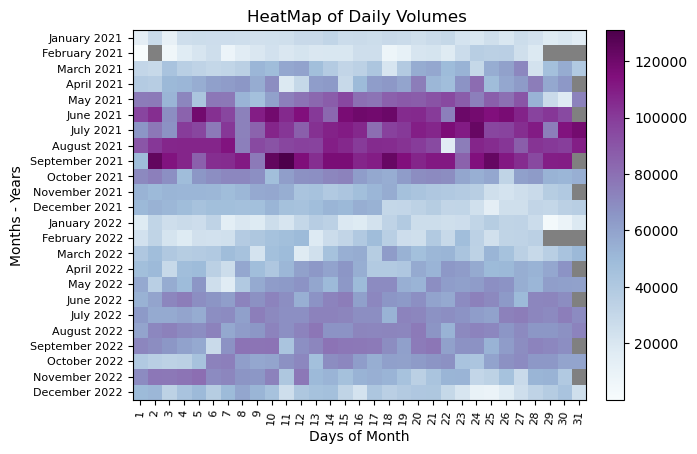

In [135]:
from load_inputs.systematic_analysis.utils import get_histogram_per_day_type,get_boxplot_per_spatial_unit_per_day_type,heatmap
from load_inputs.systematic_analysis.utils import IN_bdc,OUT_bdc,IN_nbdc,OUT_nbdc

stats = 'count'
signal = 'out'
mode = 'manhattan_bike'
city = 'Manhattan'
df_raw = pivoted_bike.copy()
palette = [OUT_bdc, OUT_nbdc]


# ==== Histogram ====
for period in ['all_day','morning_peak','evening_peak']:
    folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/{mode}"
    save_path = f'{folder}/{mode}_hist_{signal}_{period}.pdf'# None 
    ts_bd, ts_nbd = get_histogram_per_day_type(df_raw,city= city,period = period,stats = stats, palette = palette,n_bins = 100,save_path= save_path)

# ==== Boxplot ====
if False: 
    # Too much stations -> impossible to use: 
    df_raw.columns.name = 'Spatial Unit ID'
    for period in ['all_day','morning_peak','evening_peak']:
        folder = f"{os.getcwd()}/load_inputs/systematic_analysis/plots/{mode}_boxplot"
        save_path = f'{folder}/{mode}_boxplot_{signal}_{period}.pdf'# None
        df_bd, df_nbd = get_boxplot_per_spatial_unit_per_day_type(df_raw,period = period,city= city, palette = palette,save_path = save_path,df_all = df_raw)

# ==== HeatMap ====
cmap = 'BuPu' # 'hot' #'YlOrRd' # 'RdYlBu'
bool_reversed= False 
folder = f"../../../home/rrochas/prediction-validation/load_inputs/systematic_analysis/plots/{mode}/{mode}_heatmap"

save_path = f'{folder}/{mode}_heatmap_{city}.pdf'# None
df_agg = heatmap(df_raw,city= city,cmap = cmap,bool_reversed = bool_reversed,
                 save_path = save_path )

# EDA Bike Dataset:

 # Load 2022 - 2024 dataset from Kaggle 

In [3]:
import os 
import glob 
import pandas as pd
import geopandas as gpd
from shapely import Point
from datetime import datetime
import pandas as pd
import numpy as np

FOLDER_PATH = '../../../../data/rrochas/raw_data/Manhattan'
SAVE_PATH = '../../../../data/rrochas/prediction_validation/Manhattan'

# Data from 2022 to 2024:
# Downloaded from https://www.kaggle.com/datasets/yaminh/mta-subway-hourly-ridership-2022-to-2024?select=MTA_Subway_Hourly_Ridership.csv
# Provided with interresting dahsboard of the data:  https://nyc-ridership-dashboard.streamlit.app/
online_ridership_df = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership.csv', index_col=0)
manhattan_online_ridership = online_ridership_df[online_ridership_df['station_complex_id'].isin(gdf['Complex ID'])]
manhattan_online_ridership.index = pd.to_datetime(manhattan_online_ridership.index)

/tmp/ipykernel_220186/948195202.py:16: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  online_ridership_df = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership.csv', index_col=0)
/tmp/ipykernel_220186/948195202.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  manhattan_online_ridership.index = pd.to_datetime(manhattan_online_ridership.index)


In [12]:
print('Number of unique days: ',len(pd.Series(manhattan_online_ridership.index.date).unique()))

Number of unique days:  139


<Axes: >

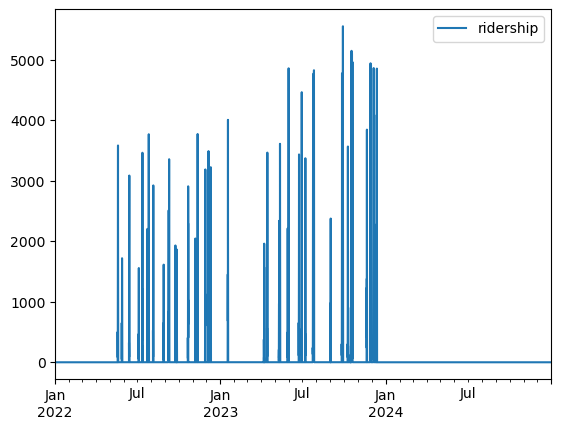

In [ ]:
local_reindex = pd.date_range(start=datetime(2022,1,1), end=datetime(2025,1,1), freq='h')[:-1]
pivoted_online_manhattan = manhattan_online_ridership.reset_index().pivot_table(index='transit_timestamp', columns='station_complex_id', values='ridership', aggfunc='sum').reindex(local_reindex)

station_complex_id = 618
df_i = manhattan_online_ridership[manhattan_online_ridership.station_complex_id == station_complex_id].sort_index()[['ridership']]
df_i.resample('h').sum().reindex(local_reindex).fillna(-1).plot()

# Others

/tmp/ipykernel_189990/2525398516.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  MTA_hourly_2020_2024 = pd.read_csv(f'{FOLDER_PATH}/MTA_Subway_Hourly_Ridership__2020-2024_20250813.csv', index_col=0)
/tmp/ipykernel_189990/2525398516.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  MTA_hourly_2020_2024.index = pd.to_datetime(MTA_hourly_2020_2024.index)


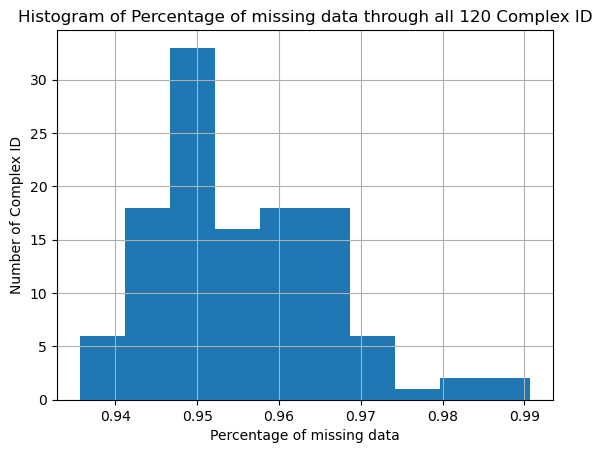

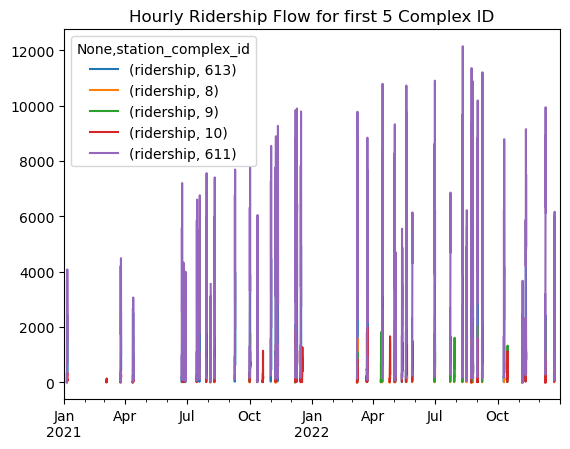

In [ ]:



# Aggregated complex_id hourly ridership data: 
grouped_hourly_complex_id = MTA_hourly_2021_2022.reset_index().groupby(['station_complex_id','transit_timestamp']).agg(latitude =('latitude', 'first'),
                                                                            longitude = ('longitude', 'first'),
                                                                            Georeference = ('Georeference', 'first'),
                                                                            ridership = ('ridership', 'sum'),
                                                                            transfers = ('transfers', 'sum')
                                                                            ).sort_index()

unique_complex_id = merged_gdf['Complex ID'].unique()
MTA_manhattan_hourly_flow = grouped_hourly_complex_id.loc[unique_complex_id][['ridership']].unstack(level=0).reindex(reindex)

# Visualize all the missing data 

# All the complex ID have more than 94% of missing data
import matplotlib.pyplot as plt
(MTA_manhattan_hourly_flow.isna().sum()/len(reindex)).hist()
plt.title(f'Histogram of Percentage of missing data through all {len(unique_complex_id)} Complex ID')
plt.xlabel('Percentage of missing data')
plt.ylabel('Number of Complex ID')
plt.show()
# Plot : 
MTA_manhattan_hourly_flow.iloc[:,:5].plot()
plt.title('Hourly Ridership Flow for first 5 Complex ID')
plt.show()

In [ ]:
reduced_df_subway_4h['datetime'] = reduced_df_subway_4h.apply(lambda row: pd.to_datetime(f"{row['date']} {row['time']}"), axis=1)
reduced_df_subway_4h = reduced_df_subway_4h.drop(columns=['date', 'time'])
reduced_df_subway_4h.groupby('Unit')

In [65]:
merged_gdf.explore(style_kwds={'radius': 10})